In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import collections

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)

In [2]:
class_names = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]

In [3]:
from torchvision import datasets, transforms

data_path = "../data-unversioned/p1ch7/"
cifar10 = datasets.CIFAR10(
    data_path,
    train=True,
    download=True,
    transform=transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.4915, 0.4823, 0.4468), (0.2470, 0.2435, 0.2616)),
        ]
    ),
)

Files already downloaded and verified


In [4]:
cifar10_val = datasets.CIFAR10(
    data_path,
    train=False,
    download=True,
    transform=transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.4915, 0.4823, 0.4468), (0.2470, 0.2435, 0.2616)),
        ]
    ),
)

Files already downloaded and verified


In [5]:
label_map = {0: 0, 2: 1}
class_names = ["airplane", "bird"]
cifar2 = [(img, label_map[label]) for img, label in cifar10 if label in [0, 2]]
cifar2_val = [(img, label_map[label]) for img, label in cifar10_val if label in [0, 2]]

In [6]:
connected_model = nn.Sequential(
    nn.Linear(3072, 1024),
    nn.Tanh(),
    nn.Linear(1024, 512),
    nn.Tanh(),
    nn.Linear(512, 128),
    nn.Tanh(),
    nn.Linear(128, 2),
)

In [7]:
numel_list = [
    p.numel() for p in connected_model.parameters() if p.requires_grad == True
]
sum(numel_list), numel_list

(3737474, [3145728, 1024, 524288, 512, 65536, 128, 256, 2])

In [8]:
first_model = nn.Sequential(
    nn.Linear(3072, 512), nn.Tanh(), nn.Linear(512, 2), nn.LogSoftmax(dim=1)
)

In [9]:
numel_list = [p.numel() for p in first_model.parameters()]
sum(numel_list), numel_list

(1574402, [1572864, 512, 1024, 2])

In [10]:
linear = nn.Linear(3072, 1024)

linear.weight.shape, linear.bias.shape

(torch.Size([1024, 3072]), torch.Size([1024]))

# Using Convolutions to classify images

In [11]:
# Here, kernel_size=3 means that the kernel is 3x3 for a 2D convolution.
conv = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=4)  # <1>
conv

Conv2d(3, 16, kernel_size=(4, 4), stride=(1, 1))

In [12]:
# The weight tensor is of shape (out_channels, in_channels, kernel_height, kernel_width).
conv.weight.shape, conv.bias.shape

(torch.Size([16, 3, 4, 4]), torch.Size([16]))

In [13]:
# We add the 0th dimension because the conv layer expects an input tensor of shape (batch_size, in_channels, height, width).
img, _ = cifar2[0]
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 29, 29]))

In [14]:
img.shape, output.shape

(torch.Size([3, 32, 32]), torch.Size([1, 16, 29, 29]))

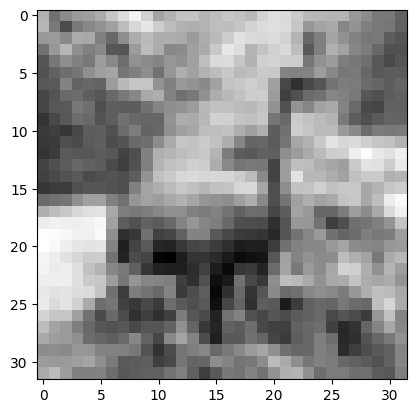

In [15]:
# We visualize the input image as a grayscale image by averaging over the channels.
plt.imshow(img.mean(0), cmap="gray")
plt.show()

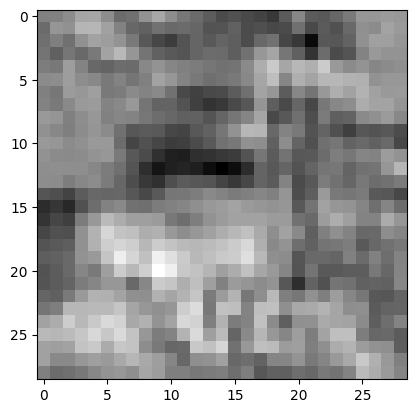

In [16]:
# 0th position in the batch, 10th output channel.
plt.imshow(output[0, 10].detach(), cmap="gray")

In [17]:
output[0, 10].shape

torch.Size([29, 29])

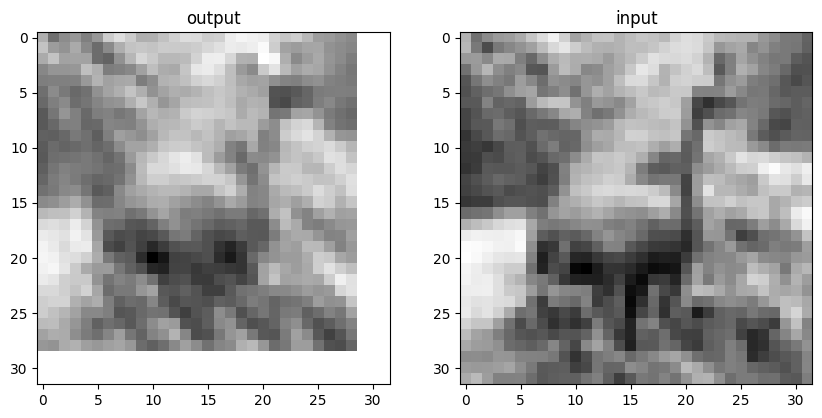

In [18]:
plt.figure(figsize=(10, 4.8))

# We print the output first and the input second to show the difference
# in shape. If we do it the other way around, the input image will be cropped.

# Here, 1, 2, 1 means 1 row, 2 columns, 1st position.
ax1 = plt.subplot(1, 2, 1)
plt.title("output")
plt.imshow(output[0, 11].detach(), cmap="gray")

# Here, 1, 2, 2 means 1 row, 2 columns, 2nd position.
# We share the x and y axes with the first subplot.
plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)
plt.title("input")
plt.imshow(img.mean(0), cmap="gray")

plt.savefig("Ch8_F2_PyTorch.png")
plt.show()

In [19]:
# We can use the padding parameter to add padding when the kernel size is odd.
# For padding even sized kernels we can use torch.nn.functional.pad.
conv = nn.Conv2d(in_channels=3, out_channels=1, kernel_size=3, padding=1)
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 1, 32, 32]))

In [20]:
from torch.nn.functional import pad

# The sequence of numbers represents the padding for each side of the input tensor.)
img.shape, pad(img, (1, 0, 0, 0)).shape, pad(img, (0, 1, 0, 0)).shape, pad(
    img, (0, 0, 1, 0)
).shape, pad(img, (0, 0, 0, 1)).shape

(torch.Size([3, 32, 32]),
 torch.Size([3, 32, 33]),
 torch.Size([3, 32, 33]),
 torch.Size([3, 33, 32]),
 torch.Size([3, 33, 32]))

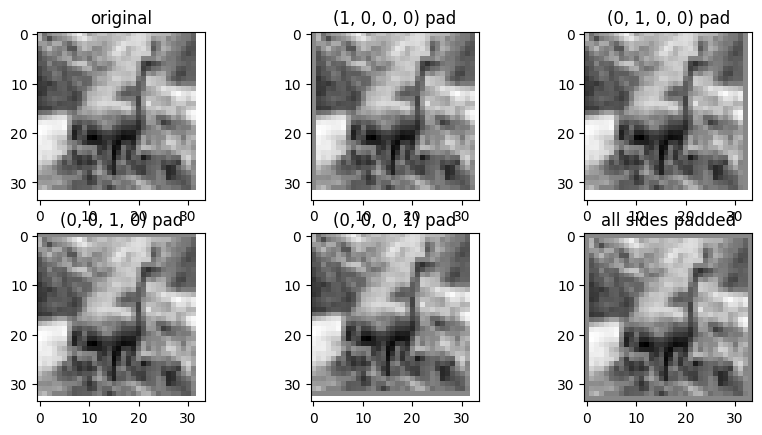

In [21]:
plt.figure(figsize=(10, 4.8))

ax1 = plt.subplot(2, 3, 1)
plt.title("original")
plt.imshow(img.mean(0), cmap="gray")

plt.subplot(2, 3, 2, sharex=ax1, sharey=ax1)
plt.title("(1, 0, 0, 0) pad")
plt.imshow(pad(img, (1, 0, 0, 0)).mean(0), cmap="gray")

plt.subplot(2, 3, 3, sharex=ax1, sharey=ax1)
plt.title("(0, 1, 0, 0) pad")
plt.imshow(pad(img, (0, 1, 0, 0)).mean(0), cmap="gray")

plt.subplot(2, 3, 4, sharex=ax1, sharey=ax1)
plt.title("(0, 0, 1, 0) pad")
plt.imshow(pad(img, (0, 0, 1, 0)).mean(0), cmap="gray")

plt.subplot(2, 3, 5, sharex=ax1, sharey=ax1)
plt.title("(0, 0, 0, 1) pad")
plt.imshow(pad(img, (0, 0, 0, 1)).mean(0), cmap="gray")

plt.subplot(2, 3, 6, sharex=ax1, sharey=ax1)
plt.title("all sides padded")
plt.imshow(pad(img, (1, 1, 1, 1)).mean(0), cmap="gray")

In [22]:
# We assign zeros to the bias tensor.
with torch.no_grad():
    conv.bias.zero_()

# We assign 1/9 to each entry of the (3, 3) convolution kernel.
# This way, each pixel will be replaced by the average of its 3x3 neighborhood.
with torch.no_grad():
    conv.weight.fill_(1.0 / 9.0)

In [23]:
# The shape of the kernel is (out_channels, in_channels, kernel_height, kernel_width).
conv.weight.shape

torch.Size([1, 3, 3, 3])

In [24]:
output = conv(img.unsqueeze(0))

# The shape of the output tensor is (batch_size, out_channels, height, width).
output.shape

torch.Size([1, 1, 32, 32])

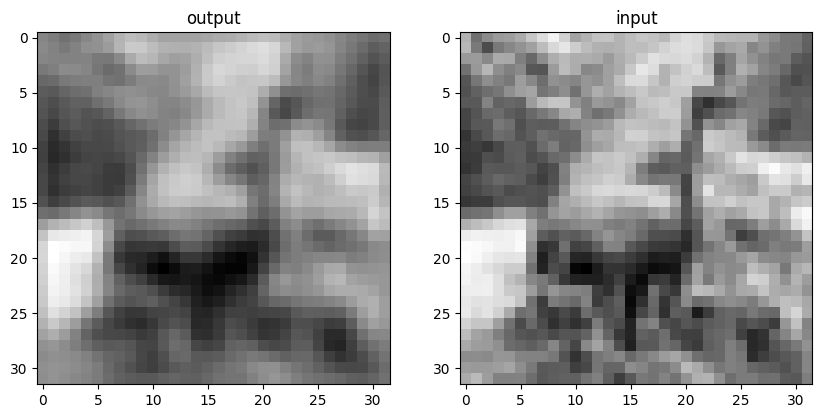

In [25]:
plt.figure(figsize=(10, 4.8))

ax1 = plt.subplot(1, 2, 1)
plt.title("output")
# We pick the 0th position in the batch and the 0th output channel.
plt.imshow(output[0, 0].detach(), cmap="gray")

plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)
plt.imshow(img.mean(0), cmap="gray")
plt.title("input")

plt.savefig("Ch8_F4_PyTorch.png")
plt.show()

In [26]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)

with torch.no_grad():
    # Edge detection kernel
    conv.weight[:] = torch.tensor(
        [[-1.0, 0.0, 1.0], [-1.0, 0.0, 1.0], [-1.0, 0.0, 1.0]]
    )
    conv.bias.zero_()

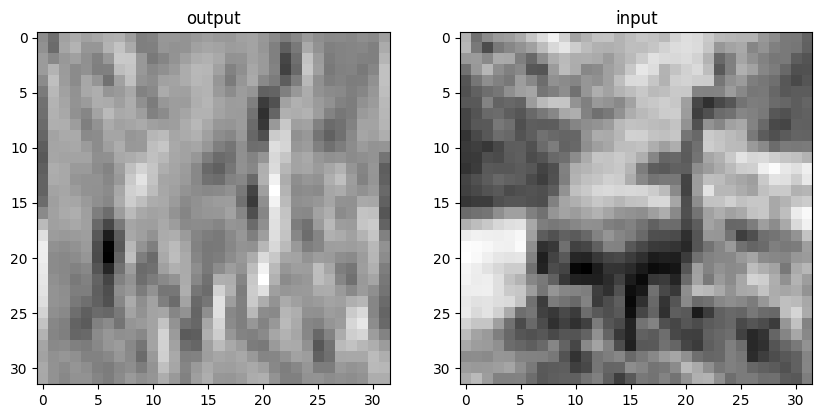

In [27]:
output = conv(img.unsqueeze(0))
plt.figure(figsize=(10, 4.8))
ax1 = plt.subplot(1, 2, 1)
plt.title("output")
plt.imshow(output[0, 0].detach(), cmap="gray")
plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)
plt.imshow(img.mean(0), cmap="gray")
plt.title("input")
plt.savefig("Ch8_F5_PyTorch.png")
plt.show()

In [28]:
pool = nn.MaxPool2d(2)
output = pool(img.unsqueeze(0))

img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 3, 16, 16]))

In [29]:
model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, padding=1),
    nn.Tanh(),
    nn.MaxPool2d(2),
    nn.Conv2d(16, 8, kernel_size=3, padding=1),
    nn.Tanh(),
    nn.MaxPool2d(2),
    # ...
)

In [30]:
model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, padding=1),
    nn.Tanh(),
    nn.MaxPool2d(2),
    nn.Conv2d(16, 8, kernel_size=3, padding=1),
    nn.Tanh(),
    nn.MaxPool2d(2),
    # ... <1>
    nn.Linear(8 * 8 * 8, 32),
    nn.Tanh(),
    nn.Linear(32, 2),
)

In [31]:
model(img.unsqueeze(0))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x8 and 512x32)

In [32]:
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

In [33]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = out.view(-1, 8 * 8 * 8)  # <1>
        out = self.act3(self.fc1(out))
        out = self.fc2(out)
        return out

In [34]:
model = Net()

numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

In [6]:
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [7]:
model = Net()
model(img.unsqueeze(0))

NameError: name 'img' is not defined

In [9]:
import datetime  # <1>


def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):  # loop over 1..n epochs
        loss_train = 0.0
        for imgs, labels in train_loader:  # loops over all batches

            outputs = model(imgs)  # forward pass of a batch

            loss = loss_fn(outputs, labels)  # compute the loss value

            optimizer.zero_grad()  # clear the gradients

            loss.backward()  # compute the gradients

            optimizer.step()  # update the weights

            # accumulate the loss value. 
            # Note that we use .item() to extract the scalar value from a tensor.
            loss_train += loss.item()

        if epoch == 1 or epoch % 10 == 0:
            print(
                "{} Epoch {}, Training loss {}".format(
                    datetime.datetime.now(), epoch, loss_train / len(train_loader)
                )
            )  # get the average loss per batch

In [61]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)

model = Net()
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs=200,
    optimizer=optimizer,
    model=model,
    loss_fn=loss_fn,
    train_loader=train_loader,
)

2025-04-06 00:19:02.289844 Epoch 1, Training loss 0.5665860762641688
2025-04-06 00:19:10.250110 Epoch 10, Training loss 0.34121537512275063
2025-04-06 00:19:19.130992 Epoch 20, Training loss 0.3055292299124086
2025-04-06 00:19:28.211594 Epoch 30, Training loss 0.2826054324010375
2025-04-06 00:19:37.381424 Epoch 40, Training loss 0.25860847561222733
2025-04-06 00:19:46.295890 Epoch 50, Training loss 0.23930322744284466
2025-04-06 00:19:55.479186 Epoch 60, Training loss 0.22342332770490342
2025-04-06 00:20:04.907251 Epoch 70, Training loss 0.20732560556880228
2025-04-06 00:20:14.147491 Epoch 80, Training loss 0.19330511878060688
2025-04-06 00:20:23.327160 Epoch 90, Training loss 0.17688288352197143
2025-04-06 00:20:32.512110 Epoch 100, Training loss 0.16575315855680758
2025-04-06 00:20:41.834549 Epoch 110, Training loss 0.15416911671495742


KeyboardInterrupt: 

In [39]:
len(train_loader) # This is the number of batches

157

In [62]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)


def validate(model, train_loader, val_loader):
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():  # we don't need gradients in the validation phase
            for imgs, labels in loader:
                outputs = model(imgs)
                # we get the indexes of the highest values in the output
                _, predicted = torch.max(outputs, dim=1)
                # sum up the number of examples in the batch
                total += labels.shape[0]

                # sum up the number of correct predictions
                correct += (predicted == labels).sum().item()

        print("Accuracy {}: {:.2f}".format(name, correct / total))


validate(model, train_loader, val_loader)

Accuracy train: 0.95
Accuracy val: 0.90


## How to save and load

In [ ]:
model.state_dict()

OrderedDict([('conv1.weight',
              tensor([[[[-1.0495e-01, -1.9907e-01,  1.4154e-01],
                        [-8.3158e-02,  1.5012e-01, -7.7436e-03],
                        [-2.6351e-02,  1.8909e-01,  2.7881e-01]],
              
                       [[-5.4061e-02, -2.4768e-01, -2.7788e-01],
                        [-2.3544e-01,  7.3760e-02,  9.8040e-03],
                        [ 5.7875e-02, -1.8359e-01, -1.7172e-01]],
              
                       [[ 5.7389e-02, -2.2570e-01, -1.1760e-01],
                        [ 1.9117e-02, -3.3285e-02, -3.0339e-01],
                        [ 1.8529e-01, -2.9753e-02, -2.5374e-01]]],
              
              
                      [[[ 6.6060e-03,  4.3787e-02,  6.3657e-05],
                        [ 3.1496e-01, -3.8151e-02, -2.1312e-01],
                        [ 1.3092e-01, -8.2160e-02, -3.8736e-01]],
              
                       [[-1.5273e-01,  1.2040e-01,  1.0886e-01],
                        [ 2.2453e-01, -1.2113

In [ ]:
torch.save(model.state_dict(), data_path + "birds_vs_airplanes.pt")

# The resulting file stores only the weights of the model.
# If we need to recreate the model, we need to instantiate the model and load the weights.

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training on device {device}.")

Training on device cuda.


In [ ]:
loaded_model = Net()  # <1>
loaded_model.load_state_dict(torch.load(data_path + "birds_vs_airplanes.pt"))

<All keys matched successfully>

In [ ]:
# PyTorch will attempt to load the weight to the same device it was saved from
# --that is, weights on the GPU will be restored to the GPU. 
# As we don’t know whether we want the same device, we have two options: 
# we could move the network to the CPU before saving it, 
# or move it back after restoring. 
# 
# It is a bit more concise to instruct PyTorch to override the device 
# information when loading weights. This is done by passing the 
# map_location keyword argument to torch.load:

# In this example we're loading the model to the GPU, but 
# it was saved from the CPU.
loaded_model = Net().to(device=device)
loaded_model.load_state_dict(
    torch.load(data_path + "birds_vs_airplanes.pt", map_location=device)
)

<All keys matched successfully>